Loading train/test splits...
X_train shape: (3392, 15)
X_test shape: (848, 15)

Setting up Grid Search for LassoNet with cross-validation...


Choosing lambda with cross-validation: 100%|██████████| 5/5 [00:23<00:00,  4.77s/it]



Best Parameters (cross-validation):
Best Lambda: 7.380418030888551
Best Cross-Validated F1-Score: 0.4583

Test Set Results:
Accuracy: 0.6156

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.73       719
           1       0.24      0.68      0.35       129

    accuracy                           0.62       848
   macro avg       0.57      0.64      0.54       848
weighted avg       0.81      0.62      0.67       848



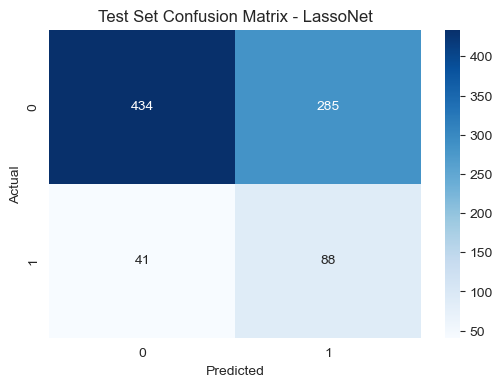

Selected Features (LassoNet): tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])
Best LassoNet model with subsampling saved to ../models/lassonet_best_model_with_subsampling.pkl


In [4]:
# --- 03_lasso_net_classifier_with_subsampling.ipynb ---

import numpy as np
import pandas as pd
from lassonet import LassoNetClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.utils import resample

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# ==============================
# Part 1: Sub-sampling the Majority Class
# ==============================

# Down-sample the majority class to balance the dataset
X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]

X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

# Down-sample majority class to match minority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority, y_majority,
                                                          replace=False,
                                                          n_samples=len(X_minority),
                                                          random_state=42)

# Combine minority class with downsampled majority class
X_resampled = np.vstack((X_majority_downsampled, X_minority))
y_resampled = np.hstack((y_majority_downsampled, y_minority))

# ==============================
# Part 2: Initialize and train the LassoNet model with Cross-validation
# ==============================

print("Setting up Grid Search for LassoNet with cross-validation...")
model = LassoNetClassifierCV()

# Fit the model with cross-validation on the resampled training data
model.fit(X_resampled, y_resampled)

# Get the best lambda from cross-validation
print("\nBest Parameters (cross-validation):")
print(f"Best Lambda: {model.best_lambda_}")
print(f"Best Cross-Validated F1-Score: {model.best_cv_score_:.4f}\n")

# 3. Evaluate the best model on the test set
y_test_pred = model.predict(X_test)

print("Test Set Results:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print()
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# 4. Confusion Matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix - LassoNet")
plt.show()

# 5. Feature Importance (Selected Features)
# The LassoNet model stores the selected features in the `best_selected_` attribute
selected_features = model.best_selected_
print(f"Selected Features (LassoNet): {selected_features}")

# 6. Save the best model to disk
os.makedirs("../models", exist_ok=True)
model_path = "../models/lassonet_best_model_with_subsampling.pkl"
joblib.dump(model, model_path)
print(f"Best LassoNet model with subsampling saved to {model_path}")

# 7. Save GridSearch Results (Optional)
# Note: Some LassoNet models may not expose `cv_results_`, so you may not be able to save them like scikit-learn.
# results_df = pd.DataFrame(model.cv_results_)
# results_df.to_csv("../results/lasso_gridsearch_results_subsampling.csv", index=False)
# print("Grid search results for subsampling saved to ../results/lasso_gridsearch_results_subsampling.csv")